Chargement des images...
Found 10141 files belonging to 1 classes.
Dataset de débruitage prêt !


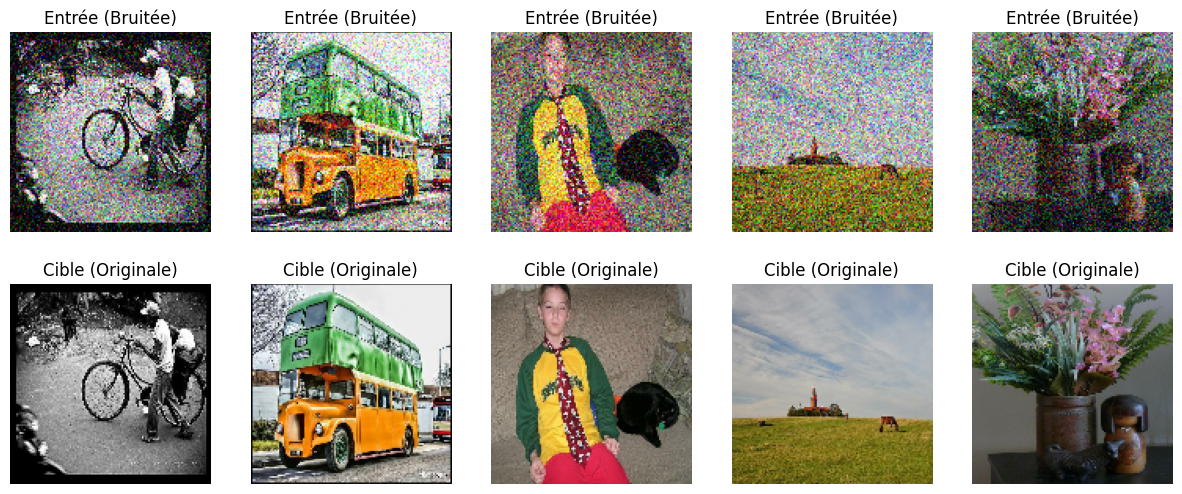

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

# --- CONFIGURATION ---
BATCH_SIZE = 32
IMG_SIZE = (128, 128)  # 128x128 suffit pour le débruitage et c'est rapide
DATA_DIR = r"C:\Users\Omen\Desktop\A5 ia conda\Dataset Livrable 2\Dataset" # Mettez le chemin vers le dossier contenant vos images (ex: Dataset Livrable 1)
NOISE_FACTOR = 0.2     # Ajustez ce chiffre (0.1 = peu de bruit, 0.5 = beaucoup)

# 1. Chargement des images "propres"
# Note : on charge tout (label_mode=None car on n'a pas besoin des classes pour le débruitage)
print("Chargement des images...")
raw_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    label_mode=None,       # Pas besoin de labels (photo/autre), on veut juste les pixels
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation='bilinear'
)

# 2. Normalisation (0 à 255 -> 0 à 1)
def normalize(image):
    return tf.cast(image, tf.float32) / 255.0

clean_ds = raw_ds.map(normalize)

# 3. Fonction pour ajouter du Bruit Gaussien
def add_noise(image):
    # Création d'un masque de bruit aléatoire
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=NOISE_FACTOR)
    
    # On ajoute le bruit à l'image
    noisy_image = image + noise
    
    # On force les valeurs à rester entre 0 et 1 (sinon ça fait des bugs d'affichage)
    noisy_image = tf.clip_by_value(noisy_image, 0.0, 1.0)
    
    # IMPORTANT : L'autoencoder attend le format (Entrée, Cible)
    # Entrée = Image Bruitée
    # Cible  = Image Propre d'origine
    return noisy_image, image

# 4. Création du dataset final (Bruité -> Propre)
train_ds = clean_ds.map(add_noise).cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

print("Dataset de débruitage prêt !")

# 5. Visualisation (Crucial pour valider le NOISE_FACTOR)
def display_noise_comparison(dataset, num_images=5):
    # On prend un batch
    noisy_batch, clean_batch = next(iter(dataset))
    
    plt.figure(figsize=(15, 6))
    for i in range(num_images):
        # Image Bruitée (Input)
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(noisy_batch[i])
        plt.title("Entrée (Bruitée)")
        plt.axis("off")

        # Image Propre (Target)
        ax = plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(clean_batch[i])
        plt.title("Cible (Originale)")
        plt.axis("off")
    plt.show()

# Afficher l'exemple
display_noise_comparison(train_ds)

In [2]:
from tensorflow.keras import layers, models

def build_autoencoder(input_shape):
    input_img = layers.Input(shape=input_shape)

    # --- ENCODEUR (Compression) ---
    # On réduit la taille (128 -> 64 -> 32)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    
    # Bottleneck (Ici l'image fait 32x32x64)
    
    # --- DECODEUR (Reconstruction) ---
    # On augmente la taille (32 -> 64 -> 128)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    
    # Couche de sortie : 3 canaux (RGB) et activation Sigmoid (pour sortir entre 0 et 1)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    # Création du modèle
    autoencoder = models.Model(input_img, decoded)
    return autoencoder

# Construction
autoencoder = build_autoencoder((128, 128, 3))

# Compilation
# 'mean_squared_error' est parfait pour le débruitage (on compare pixel par pixel)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        36928 

In [3]:
# On divise le dataset 'train_ds' créé à l'étape précédente
val_size = int(len(train_ds) * 0.2)
train_size = len(train_ds) - val_size

train_data = train_ds.take(train_size)
val_data = train_ds.skip(train_size)

print(f"Batches d'entraînement : {len(train_data)}")
print(f"Batches de validation : {len(val_data)}")

Batches d'entraînement : 254
Batches de validation : 63


In [4]:
from tensorflow.keras.callbacks import EarlyStopping

# Arrêt automatique si ça ne s'améliore plus
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = autoencoder.fit(
    train_data,
    epochs=20, # 20 époques suffisent souvent pour du débruitage simple
    validation_data=val_data,
    callbacks=[early_stop]
)

# Sauvegarde du modèle (Livrable 2 terminé !)
autoencoder.save('touNum_denoiser.keras')

Epoch 1/20
254/254 [==============================] - 16s 32ms/step - loss: 0.0167 - val_loss: 0.0118
Epoch 2/20
254/254 [==============================] - 8s 30ms/step - loss: 0.0103 - val_loss: 0.0096
Epoch 3/20
254/254 [==============================] - 8s 30ms/step - loss: 0.0094 - val_loss: 0.0092
Epoch 4/20
254/254 [==============================] - 8s 30ms/step - loss: 0.0089 - val_loss: 0.0088
Epoch 5/20
254/254 [==============================] - 7s 29ms/step - loss: 0.0086 - val_loss: 0.0084
Epoch 6/20
254/254 [==============================] - 7s 29ms/step - loss: 0.0083 - val_loss: 0.0080
Epoch 7/20
254/254 [==============================] - 7s 29ms/step - loss: 0.0081 - val_loss: 0.0079
Epoch 8/20
254/254 [==============================] - 8s 30ms/step - loss: 0.0079 - val_loss: 0.0077
Epoch 9/20
254/254 [==============================] - 8s 30ms/step - loss: 0.0077 - val_loss: 0.0076
Epoch 10/20
254/254 [==============================] - 7s 30ms/step - loss: 0.0074 - val_l

1/1 [==============================] - 0s 116ms/step


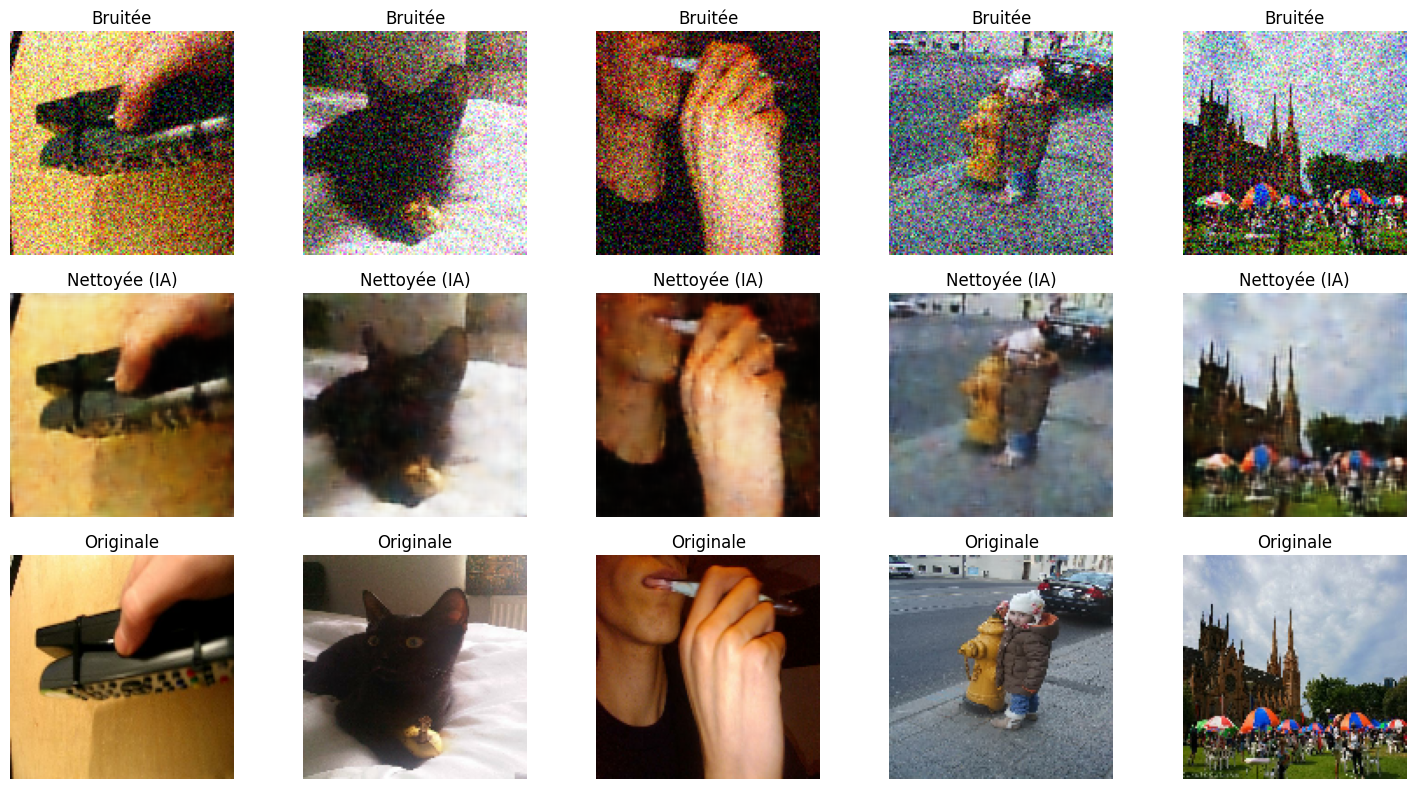

In [6]:
def show_predictions(dataset, model, num=5):
    # Récupérer un batch
    noisy_batch, clean_batch = next(iter(dataset))
    
    # Faire les prédictions (nettoyage)
    denoised_batch = model.predict(noisy_batch)
    
    plt.figure(figsize=(15, 8))
    for i in range(num):
        # 1. Image Bruitée
        ax = plt.subplot(3, num, i + 1)
        plt.imshow(noisy_batch[i])
        plt.title("Bruitée")
        plt.axis("off")
        
        # 2. Résultat de l'IA
        ax = plt.subplot(3, num, i + 1 + num)
        plt.imshow(denoised_batch[i])
        plt.title("Nettoyée (IA)")
        plt.axis("off")

        # 3. Originale
        ax = plt.subplot(3, num, i + 1 + num * 2)
        plt.imshow(clean_batch[i])
        plt.title("Originale")
        plt.axis("off")
        
    plt.tight_layout()
    plt.show()

# Lancer la démo sur le set de validation (images jamais vues pendant l'entraînement)
show_predictions(val_data, autoencoder)

Construction du U-Net...
Model: "U-Net_Denoiser"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 128, 128, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_6 (Conv2D)              (None, 128, 128, 32  9248        ['conv2d_5[0][0]']               
                                )                           

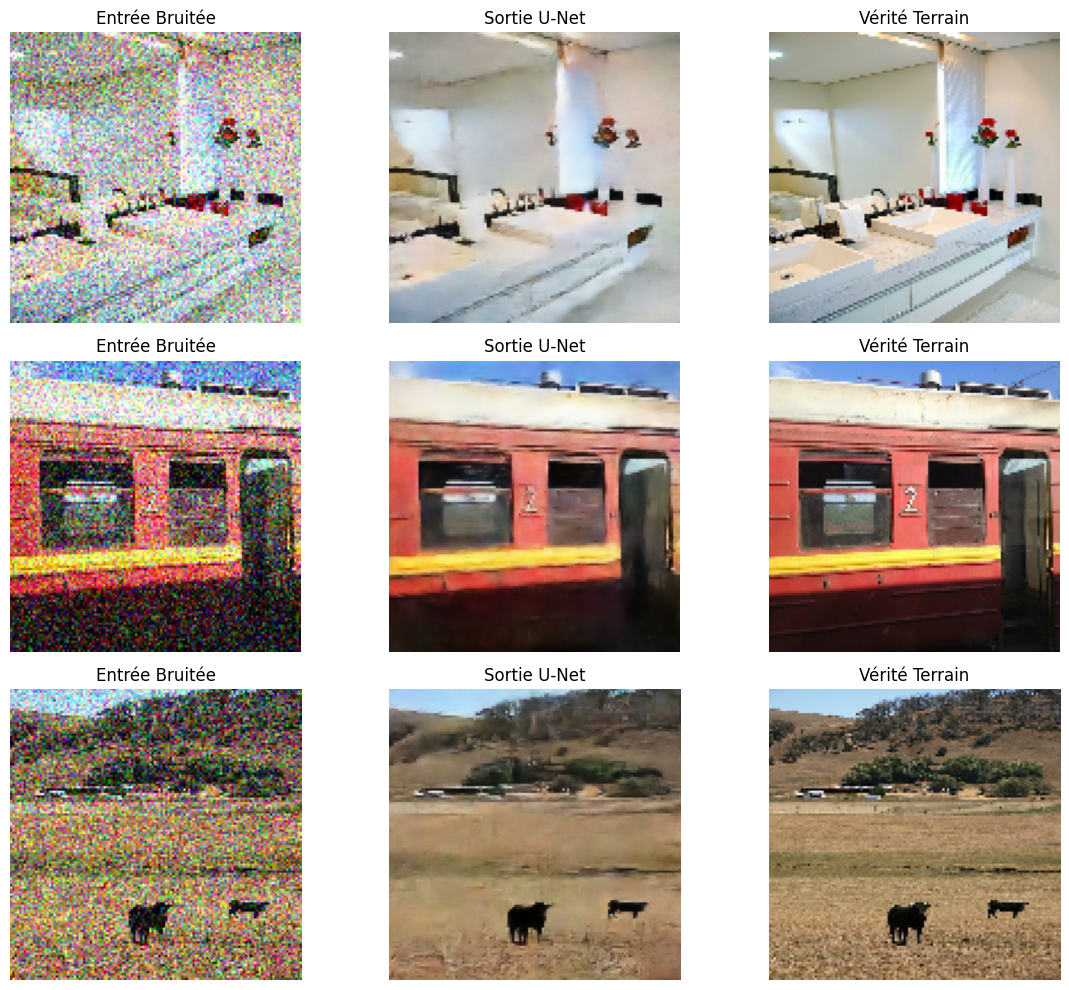

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# --- 1. ARCHITECTURE U-NET ---
def build_unet_denoiser(input_shape):
    inputs = Input(input_shape)

    # === ENCODEUR (Descente) ===
    # Niveau 1
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1) # Double convolution
    p1 = layers.MaxPooling2D((2, 2))(c1)

    # Niveau 2
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # === BOTTLENECK (Le fond du U) ===
    b = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    b = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(b)

    # === DECODEUR (Montée avec Skip Connections) ===
    # Niveau 2 (Montée)
    u1 = layers.UpSampling2D((2, 2))(b)
    u1 = layers.Concatenate()([u1, c2]) # <--- SKIP CONNECTION : On recolle c2
    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u1)
    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c3)

    # Niveau 1 (Montée)
    u2 = layers.UpSampling2D((2, 2))(c3)
    u2 = layers.Concatenate()([u2, c1]) # <--- SKIP CONNECTION : On recolle c1
    c4 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u2)
    c4 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c4)

    # === SORTIE ===
    outputs = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(c4)

    model = models.Model(inputs, outputs, name="U-Net_Denoiser")
    return model

# --- 2. CONSTRUCTION ET COMPILATION ---
print("Construction du U-Net...")
unet = build_unet_denoiser((128, 128, 3))

# On garde 'mse' pour comparer, mais 'mae' donne parfois des résultats plus nets visuellement
unet.compile(optimizer='adam', loss='mean_squared_error')
unet.summary()

# --- 3. ENTRAÎNEMENT ---
print("\nDémarrage de l'entraînement...")
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# On utilise les mêmes données que précédemment (train_data, val_data)
history_unet = unet.fit(
    train_data,
    epochs=25,
    validation_data=val_data,
    callbacks=[early_stop]
)

# Sauvegarde
unet.save('touNum_denoiser_unet.keras')

# --- 4. TEST VISUEL FINAL ---
def show_predictions_unet(dataset, model, num=3):
    noisy_batch, clean_batch = next(iter(dataset))
    denoised_batch = model.predict(noisy_batch)
    
    plt.figure(figsize=(12, 10))
    for i in range(num):
        # Bruitée
        plt.subplot(num, 3, i*3 + 1)
        plt.imshow(noisy_batch[i])
        plt.title("Entrée Bruitée")
        plt.axis("off")
        
        # U-Net
        plt.subplot(num, 3, i*3 + 2)
        plt.imshow(denoised_batch[i])
        plt.title("Sortie U-Net")
        plt.axis("off")

        # Originale
        plt.subplot(num, 3, i*3 + 3)
        plt.imshow(clean_batch[i])
        plt.title("Vérité Terrain")
        plt.axis("off")
        
    plt.tight_layout()
    plt.show()

print("\nAffichage des résultats...")
show_predictions_unet(val_data, unet)